## Detección de anomalías con LSTM

In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Cargar los datos
df = pd.read_csv('bitcoin_minute_data.csv', parse_dates=['timestamp'], index_col='timestamp')

# Preparar los datos
df['log_return'] = np.log(df['close'].astype(float) / df['close'].astype(float).shift(1))
df.dropna(inplace=True)

# Dividir en sets de entrenamiento, validación y prueba (70%, 15%, 15%)
train_size = int(len(df) * 0.7)
valid_size = int(len(df) * 0.15)
test_size = len(df) - train_size - valid_size

train_data = df[:train_size]
valid_data = df[train_size:train_size + valid_size]
test_data = df[train_size + valid_size:]

# Normalizar los datos
scaler = StandardScaler()
train_data['log_return_scaled'] = scaler.fit_transform(train_data[['log_return']])
valid_data['log_return_scaled'] = scaler.transform(valid_data[['log_return']])
test_data['log_return_scaled'] = scaler.transform(test_data[['log_return']])

# Función para crear dataset para LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data['log_return_scaled'].values.reshape(-1, 1), time_step)
X_valid, y_valid = create_dataset(valid_data['log_return_scaled'].values.reshape(-1, 1), time_step)
X_test, y_test = create_dataset(test_data['log_return_scaled'].values.reshape(-1, 1), time_step)

# Reshape X para LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Crear y entrenar el modelo LSTM
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/20


/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_26038/110715729.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_return_scaled'] = scaler.fit_transform(train_data[['log_return']])
/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_26038/110715729.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['log_return_scaled'] = scaler.transform(valid_data[['log_return']])
/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_26038/110715729.py:28: SettingWithC

6045/6045 ━━━━━━━━━━━━━━━━━━━━ 87s 14ms/step - loss: 1.0247 - val_loss: 0.4302
Epoch 2/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 87s 14ms/step - loss: 1.0059 - val_loss: 0.4305
Epoch 3/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - loss: 1.0101 - val_loss: 0.4308
Epoch 4/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - loss: 0.9739 - val_loss: 0.4304
Epoch 5/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 87s 14ms/step - loss: 1.0170 - val_loss: 0.4330
Epoch 6/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 87s 14ms/step - loss: 0.9806 - val_loss: 0.4321
Epoch 7/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - loss: 0.9952 - val_loss: 0.4302
Epoch 8/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - loss: 1.0020 - val_loss: 0.4320
Epoch 9/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 88s 14ms/step - loss: 0.9839 - val_loss: 0.4302
Epoch 10/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 87s 14ms/step - loss: 0.9958 - val_loss: 0.4306
Epoch 11/20
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step - loss: 0.9926 - val_loss: 0.4310
Epoch 12/20
6045/60

In [53]:


# Hacer predicciones y detectar anomalías en el set de prueba
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular errores
errors = np.abs(y_test_true - predictions)

# Determinar el umbral para anomalías (por ejemplo, 2 veces la desviación estándar)
threshold = 3 * np.std(errors)

# Detectar anomalías
test_data['anomaly_lstm'] = False
test_data.iloc[time_step+1:, test_data.columns.get_loc('anomaly_lstm')] = (errors > threshold).flatten()

# Guardar resultados
test_data.to_csv('anomalies_lstm.csv')
print("Anomalías detectadas con LSTM guardadas en 'anomalies_lstm.csv'")


1294/1294 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_26038/2101386551.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['anomaly_lstm'] = False


Anomalías detectadas con LSTM guardadas en 'anomalies_lstm.csv'


## Detección de anomalías con ARIMA

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Cargar los datos
df = pd.read_csv('bitcoin_minute_data.csv', parse_dates=['timestamp'], index_col='timestamp')

# Establecer la frecuencia del índice de tiempo a 'T' para indicar que es por minuto
df = df.asfreq('min')

# Preparar los datos
df['log_return'] = np.log(df['close'].astype(float) / df['close'].astype(float).shift(1))
df.dropna(inplace=True)

# Dividir en sets de entrenamiento y prueba (70%, 30%)
train_size = int(len(df) * 0.7)
train_data = df[:train_size]
test_data = df[train_size:]

# ARIMA en el set de entrenamiento
model_arima = ARIMA(train_data['log_return'], order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# Hacer predicciones y detectar anomalías en el set de prueba con ARIMA
test_data['forecast_arima'] = model_arima_fit.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
test_data['residual_arima'] = test_data['log_return'] - test_data['forecast_arima']

# Calcular el umbral para anomalías (por ejemplo, 2 veces la desviación estándar de los residuos)
threshold_arima = 3 * np.std(test_data['residual_arima'])

# Detectar anomalías
test_data['anomaly_arima'] = (np.abs(test_data['residual_arima']) > threshold_arima)

# Guardar resultados
test_data.to_csv('anomalies_arima.csv')
print("Anomalías detectadas con ARIMA guardadas en 'anomalies_arima.csv'")


/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_26775/3705911212.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['forecast_arima'] = model_arima_fit.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
/var/fold

Anomalías detectadas con ARIMA guardadas en 'anomalies_arima.csv'


## Detección de anomalías con DBSCAN

In [65]:
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Cargar los datos
df = pd.read_csv('bitcoin_minute_data.csv', parse_dates=['timestamp'], index_col='timestamp')

# Preparar los datos
df['log_return'] = np.log(df['close'].astype(float) / df['close'].astype(float).shift(1))
df.dropna(inplace=True)

# Submuestrear los datos (por ejemplo, usar solo el 10% de los datos)
df_sampled = df.sample(frac=0.3, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(df_sampled[['log_return']])

# Aplicar DBSCAN
db = DBSCAN(eps=0.5, min_samples=20).fit(X)
df_sampled['anomaly_dbscan'] = db.labels_

# Etiquetar las anomalías (outliers)
df_sampled['anomaly_dbscan'] = df_sampled['anomaly_dbscan'] == -1

# Guardar resultados
df_sampled.to_csv('anomalies_dbscan_sampled.csv')
print("Anomalías detectadas con DBSCAN guardadas en 'anomalies_dbscan_sampled.csv'")
'''


## HDBSCAN

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import hdbscan

# Cargar los datos
df = pd.read_csv('bitcoin_minute_data.csv', parse_dates=['timestamp'], index_col='timestamp')

# Preparar los datos
df['log_return'] = np.log(df['close'].astype(float) / df['close'].astype(float).shift(1))
df.dropna(inplace=True)

# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(df[['log_return']])

# Aplicar HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
df['anomaly_hdbscan'] = clusterer.fit_predict(X)

# Etiquetar las anomalías (outliers son etiquetados como -1 en HDBSCAN)
df['anomaly_hdbscan'] = df['anomaly_hdbscan'] == -1

# Guardar resultados
df.to_csv('anomalies_hdbscan.csv')
print("Anomalías detectadas con HDBSCAN guardadas en 'anomalies_hdbscan.csv'")


Anomalías detectadas con HDBSCAN guardadas en 'anomalies_hdbscan.csv'


## Visualización de Anomalías

/var/folders/gd/q32w8wgd1bxc7wq53vd9nts80000gn/T/ipykernel_26775/1843050598.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anomalies_lstm = df_price[df_lstm['anomaly_lstm']]


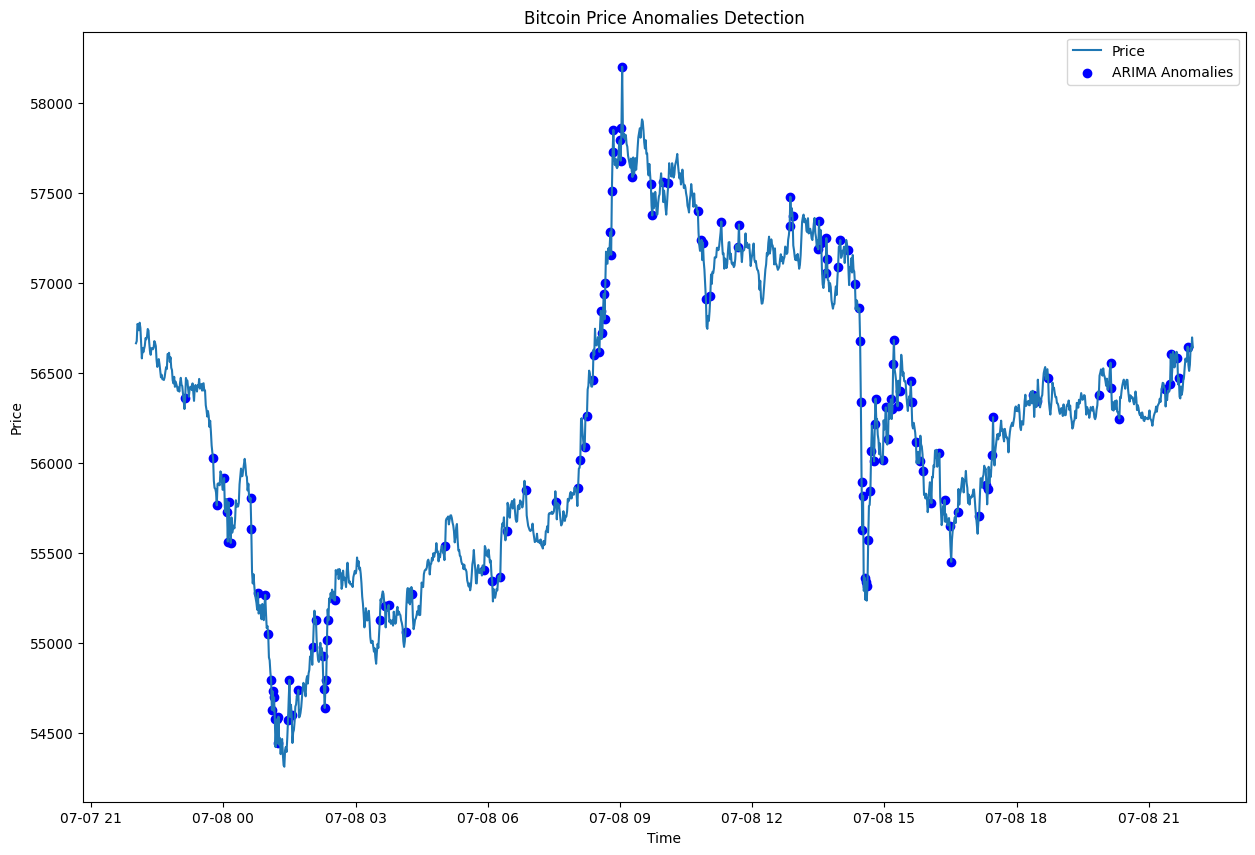

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

ini = -60*24*3
end = -60*24*2

# Cargar los datos
df_lstm = pd.read_csv('anomalies_lstm.csv', parse_dates=['timestamp'], index_col='timestamp')
df_arima = pd.read_csv('anomalies_arima.csv', parse_dates=['timestamp'], index_col='timestamp')
df_dbscan = pd.read_csv('anomalies_hdbscan.csv', parse_dates=['timestamp'], index_col='timestamp')

df_price = df_arima
df_price['anomaly_lstm'] = df_lstm['anomaly_lstm']
df_price['anomaly_arima'] = df_arima['anomaly_arima']
df_price['anomaly_hdbscan'] = df_dbscan['anomaly_hdbscan']

plt.figure(figsize=(15, 10))

# Graficar precios
df_price = df_price[ini:end]
plt.plot(df_price.index, df_price['price'], label='Price')

# Anomalías LSTM
anomalies_lstm = df_price[df_lstm['anomaly_lstm']]
#plt.scatter(anomalies_lstm.index, anomalies_lstm['close'], color='olive', label='LSTM Anomalies')

# Anomalías ARIMA
anomalies_arima = df_price[df_price['anomaly_arima']]
plt.scatter(anomalies_arima.index, anomalies_arima['price'], color='blue', label='ARIMA Anomalies')

# Anomalías DBSCAN
anomalies_dbscan = df_price[df_price['anomaly_hdbscan']]
#plt.scatter(anomalies_dbscan.index, anomalies_dbscan['price'], color='green', label='DBSCAN Anomalies')

#Grouped anomalies
anomalies_grouped = df_price[df_price['anomaly_arima'] & df_price['anomaly_lstm']]
#plt.scatter(anomalies_grouped.index, anomalies_grouped['price'], color='red', label='ALL Anomalies')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Price Anomalies Detection')
plt.legend()
plt.show()
